In [83]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

import math

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img

%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset
from utils.functions import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Vector multiplication (degree = 1)

@BACC_Enc: N,K,T, m_i= 200 2 3 1 



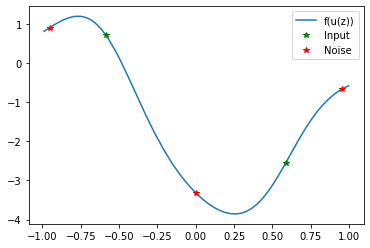

In [53]:
K = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)
        
P = 1
d = 2

X = np.random.normal(0,P,size=(K,d))
a = np.random.normal(0,P,size=(1,d))
Noise = np.random.normal(0,sigma,size=(T,d))

y_true = np.matmul(a, np.transpose(X))
y_noise = np.matmul(a, np.transpose(Noise))

j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))






@BACC_Enc: N,K,T, m_i= 200 2 3 1 

@BACC_Enc: N,K,T, m_i= 200 2 3 1 



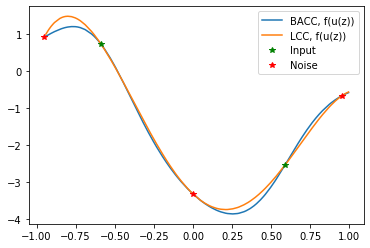

In [87]:
N = 200
z_array = np.random.uniform(-1,1,N) #np.cos(i_array[1:]*2*math.pi/(K+T)/2) # np.cos(i_array*2*math.pi/N/2)
z_array = np.sort(z_array)

X_tilde,_,_ = BACC_Enc_Data_v3(X, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = Noise, is_predefined_noise=True ,_is_LCC=False) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
y_tilde = np.empty((1,N))

X_LCC,_,_ = BACC_Enc_Data_v3(X, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = Noise, is_predefined_noise=True ,_is_LCC=True) 
y_LCC = np.empty((1,N))

y_tilde = np.empty((1,N))
y_LCC = np.empty((1,N))
for i in range(N):
    
    y_tilde[0,i] = np.matmul(a, np.transpose(X_tilde[i,:,:]))
    y_LCC[0,i] = np.matmul(a, np.transpose(X_LCC[i,:,:]))
#     print(np.shape(tmp))
#     y_tilde[0,i] = tmp


plt.plot(z_array,y_tilde[0,:],label='BACC, f(u(z))')
plt.plot(z_array,y_LCC[0,:],label='LCC, f(u(z))')
plt.plot(alpha_array[Signal_Alloc], y_true[0,:],'g*',label='Input')
plt.plot(alpha_array[Noise_Alloc], y_noise[0,:],'r*',label='Noise')
plt.legend()
plt.show()

[-0.10835848  0.18211977  0.22143424  0.83506014]
@BACC_Enc: N,K,T, m_i= 4 2 3 1 

chekc the length! 4 4
@BACC_Enc: N,K,T, m_i= 4 2 3 1 



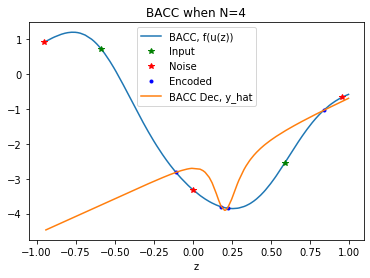

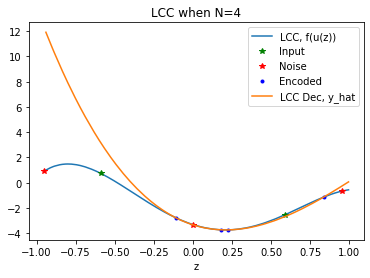

In [105]:
N = 4

B= 0.5
z_sel = []
while(len(z_sel)<N):
    z_tmp = np.random.uniform(-1,1,1)
    MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], P,sigma)
    if MIS_tmp < B and MIS_tmp > 0.1:
        z_sel.append(z_tmp[0])
z_sel = np.sort(z_sel)

print(z_sel)

X_tilde_,_,_ = BACC_Enc_Data_v3(X, N, K, T, sigma, alpha_array, z_sel, _Noise_Alloc = Noise_Alloc, _Noise = Noise, is_predefined_noise=True ,_is_LCC=False) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
y_tilde_ = np.empty((N,1,1))
for i in range(N):    
    y_tilde_[i,0,0] = np.matmul(a, np.transpose(X_tilde_[i,:,:]))

y_dec = BACC_Dec(y_tilde_, z_array,z_sel)


X_LCC_,_,_ = BACC_Enc_Data_v3(X, N, K, T, sigma, alpha_array, z_sel, _Noise_Alloc = Noise_Alloc, _Noise = Noise, is_predefined_noise=True ,_is_LCC=True) 
y_LCC_ = np.empty((N,1,1))
for i in range(N):    
    y_LCC_[i,0,0] = np.matmul(a, np.transpose(X_LCC_[i,:,:]))

y_dec_LCC = LCC_Dec(y_LCC_, z_array, z_sel)

plt.plot(z_array,y_tilde[0,:],label='BACC, f(u(z))')
plt.plot(alpha_array[Signal_Alloc], y_true[0,:],'g*',label='Input')
plt.plot(alpha_array[Noise_Alloc], y_noise[0,:],'r*',label='Noise')
plt.plot(z_sel,y_tilde_[:,0,0],'b.',label='Encoded')
plt.plot(z_array,y_dec[:,0,0],label='BACC Dec, y_hat')
plt.legend()
plt.xlabel('z')
plt.title('BACC when N='+str(N))
plt.show()



plt.plot(z_array,y_LCC[0,:],label='LCC, f(u(z))')
plt.plot(alpha_array[Signal_Alloc], y_true[0,:],'g*',label='Input')
plt.plot(alpha_array[Noise_Alloc], y_noise[0,:],'r*',label='Noise')
plt.plot(z_sel,y_LCC_[:,0,0],'b.',label='Encoded')
plt.plot(z_array,y_dec_LCC[:,0,0],label='LCC Dec, y_hat')
plt.legend()
plt.xlabel('z')
plt.title('LCC when N='+str(N))
plt.show()

[-0.9  -0.81 -0.22 -0.16  0.22  0.81]
@BACC_Enc: N,K,T, m_i= 6 2 3 1 

chekc the length! 6 6
@BACC_Enc: N,K,T, m_i= 6 2 3 1 



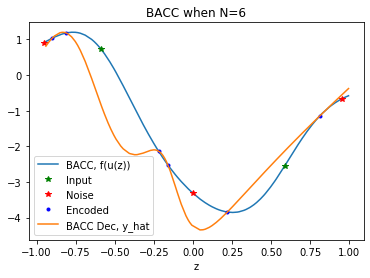

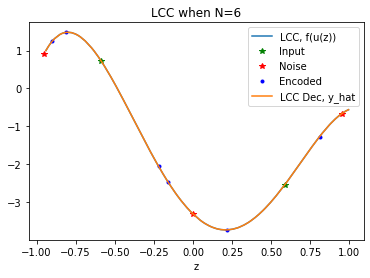

In [100]:
N = 6
z_sel = np.array([-0.9, -0.81,-0.22,-0.16,                           0.22,  0.81])

print(z_sel)

X_tilde_,_,_ = BACC_Enc_Data_v3(X, N, K, T, sigma, alpha_array, z_sel, _Noise_Alloc = Noise_Alloc, _Noise = Noise, is_predefined_noise=True ,_is_LCC=False) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
y_tilde_ = np.empty((N,1,1))
for i in range(N):    
    y_tilde_[i,0,0] = np.matmul(a, np.transpose(X_tilde_[i,:,:]))

y_dec = BACC_Dec(y_tilde_, z_array,z_sel)


X_LCC_,_,_ = BACC_Enc_Data_v3(X, N, K, T, sigma, alpha_array, z_sel, _Noise_Alloc = Noise_Alloc, _Noise = Noise, is_predefined_noise=True ,_is_LCC=True) 
y_LCC_ = np.empty((N,1,1))
for i in range(N):    
    y_LCC_[i,0,0] = np.matmul(a, np.transpose(X_LCC_[i,:,:]))

y_dec_LCC = LCC_Dec(y_LCC_, z_array, z_sel)

plt.plot(z_array,y_tilde[0,:],label='BACC, f(u(z))')
plt.plot(alpha_array[Signal_Alloc], y_true[0,:],'g*',label='Input')
plt.plot(alpha_array[Noise_Alloc], y_noise[0,:],'r*',label='Noise')
plt.plot(z_sel,y_tilde_[:,0,0],'b.',label='Encoded')
plt.plot(z_array,y_dec[:,0,0],label='BACC Dec, y_hat')
plt.legend()
plt.xlabel('z')
plt.title('BACC when N='+str(N))
plt.show()



plt.plot(z_array,y_LCC[0,:],label='LCC, f(u(z))')
plt.plot(alpha_array[Signal_Alloc], y_true[0,:],'g*',label='Input')
plt.plot(alpha_array[Noise_Alloc], y_noise[0,:],'r*',label='Noise')
plt.plot(z_sel,y_LCC_[:,0,0],'b.',label='Encoded')
plt.plot(z_array,y_dec_LCC[:,0,0],label='LCC Dec, y_hat')
plt.legend()
plt.xlabel('z')
plt.title('LCC when N='+str(N))
plt.show()

# Max function

In [109]:
y_true = np.max(X,axis=1)
y_noise = np.max(Noise, axis=1)



@BACC_Enc: N,K,T, m_i= 200 2 3 1 

@BACC_Enc: N,K,T, m_i= 200 2 3 1 



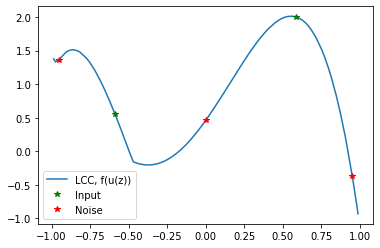

In [120]:
N = 200
z_array = np.random.uniform(-1,1,N) #np.cos(i_array[1:]*2*math.pi/(K+T)/2) # np.cos(i_array*2*math.pi/N/2)
z_array = np.sort(z_array)

X_tilde,_,_ = BACC_Enc_Data_v3(X, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = Noise, is_predefined_noise=True ,_is_LCC=False) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
y_tilde = np.empty((1,N))

X_LCC,_,_ = BACC_Enc_Data_v3(X, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = Noise, is_predefined_noise=True ,_is_LCC=True) 
y_LCC = np.empty((1,N))

y_tilde = np.empty((1,N))
y_LCC = np.empty((1,N))

for i in range(N):
    
    y_tilde[0,i] = np.max(X_tilde[i,:,:])
    y_LCC[0,i] = np.max(X_LCC[i,:,:])
#     print(np.shape(tmp))
#     y_tilde[0,i] = tmp


# plt.plot(z_array,y_tilde[0,:],label='BACC, f(u(z))')
plt.plot(z_array,y_LCC[0,:],label='LCC, f(u(z))')
plt.plot(alpha_array[Signal_Alloc], y_true[:],'g*',label='Input')
plt.plot(alpha_array[Noise_Alloc], y_noise[:],'r*',label='Noise')
plt.legend()
plt.show()

[-0.87034814 -0.85990615 -0.22582893  0.13785818  0.82555167]
@BACC_Enc: N,K,T, m_i= 5 2 3 1 

chekc the length! 5 5
@BACC_Enc: N,K,T, m_i= 5 2 3 1 



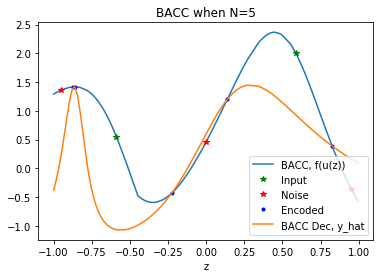

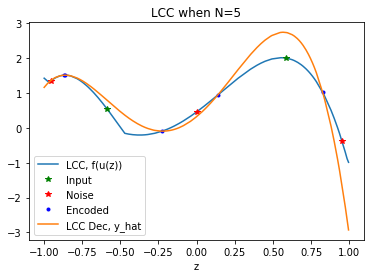

In [119]:
N = 5

B= 0.5
z_sel = []
while(len(z_sel)<N):
    z_tmp = np.random.uniform(-1,1,1)
    MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], P,sigma)
    if MIS_tmp < B and MIS_tmp > 0.1:
        z_sel.append(z_tmp[0])
z_sel = np.sort(z_sel)

print(z_sel)

X_tilde_,_,_ = BACC_Enc_Data_v3(X, N, K, T, sigma, alpha_array, z_sel, _Noise_Alloc = Noise_Alloc, _Noise = Noise, is_predefined_noise=True ,_is_LCC=False) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
y_tilde_ = np.empty((N,1,1))
for i in range(N):    
    y_tilde_[i,0,0] = np.max(X_tilde_[i,:,:])

y_dec = BACC_Dec(y_tilde_, z_array,z_sel)


X_LCC_,_,_ = BACC_Enc_Data_v3(X, N, K, T, sigma, alpha_array, z_sel, _Noise_Alloc = Noise_Alloc, _Noise = Noise, is_predefined_noise=True ,_is_LCC=True) 
y_LCC_ = np.empty((N,1,1))
for i in range(N):    
    y_LCC_[i,0,0] = np.max(X_LCC_[i,:,:])

y_dec_LCC = LCC_Dec(y_LCC_, z_array, z_sel)

plt.plot(z_array,y_tilde[0,:],label='BACC, f(u(z))')
plt.plot(alpha_array[Signal_Alloc], y_true[:],'g*',label='Input')
plt.plot(alpha_array[Noise_Alloc], y_noise[:],'r*',label='Noise')
plt.plot(z_sel,y_tilde_[:,0,0],'b.',label='Encoded')
plt.plot(z_array,y_dec[:,0,0],label='BACC Dec, y_hat')
plt.legend()
plt.xlabel('z')
plt.title('BACC when N='+str(N))
plt.show()



plt.plot(z_array,y_LCC[0,:],label='LCC, f(u(z))')
plt.plot(alpha_array[Signal_Alloc], y_true[:],'g*',label='Input')
plt.plot(alpha_array[Noise_Alloc], y_noise[:],'r*',label='Noise')
plt.plot(z_sel,y_LCC_[:,0,0],'b.',label='Encoded')
plt.plot(z_array,y_dec_LCC[:,0,0],label='LCC Dec, y_hat')
plt.legend()
plt.xlabel('z')
plt.title('LCC when N='+str(N))
plt.show()

@BACC_Enc: N,K,T, m_i= 200 2 3 1 

@BACC_Enc: N,K,T, m_i= 200 2 3 1 



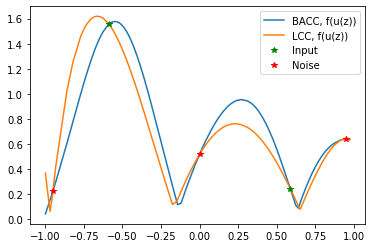

In [131]:
K = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)
        
P = 1
d = 2

X = np.random.normal(0,P,size=(K,d))
a = np.random.normal(0,P,size=(1,d))
Noise = np.random.normal(0,sigma,size=(T,d))

y_true = np.matmul(a, np.transpose(X))
y_noise = np.matmul(a, np.transpose(Noise))

j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))


y_true = np.max(X,axis=1)
y_noise = np.max(Noise, axis=1)

N = 200
z_array = np.random.uniform(-1,1,N) #np.cos(i_array[1:]*2*math.pi/(K+T)/2) # np.cos(i_array*2*math.pi/N/2)
z_array = np.sort(z_array)

X_tilde,_,_ = BACC_Enc_Data_v3(X, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = Noise, is_predefined_noise=True ,_is_LCC=False) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
y_tilde = np.empty((1,N))

X_LCC,_,_ = BACC_Enc_Data_v3(X, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = Noise, is_predefined_noise=True ,_is_LCC=True) 
y_LCC = np.empty((1,N))

y_tilde = np.empty((1,N))
y_LCC = np.empty((1,N))

for i in range(N):
    
    y_tilde[0,i] = np.max(X_tilde[i,:,:])
    y_LCC[0,i] = np.max(X_LCC[i,:,:])
#     print(np.shape(tmp))
#     y_tilde[0,i] = tmp


plt.plot(z_array,y_tilde[0,:],label='BACC, f(u(z))')
plt.plot(z_array,y_LCC[0,:],label='LCC, f(u(z))')
plt.plot(alpha_array[Signal_Alloc], y_true[:],'g*',label='Input')
plt.plot(alpha_array[Noise_Alloc], y_noise[:],'r*',label='Noise')
plt.legend()
plt.show()


[-0.81408978 -0.21582117 -0.18050101 -0.1315216   0.18563282  0.86394117]
@BACC_Enc: N,K,T, m_i= 6 2 3 1 

chekc the length! 6 6
@BACC_Enc: N,K,T, m_i= 6 2 3 1 



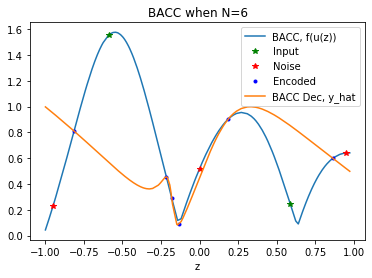

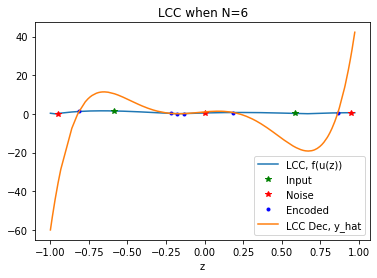

In [135]:
N = 6

B= 0.5
z_sel = []
while(len(z_sel)<N):
    z_tmp = np.random.uniform(-1,1,1)
    MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], P,sigma)
    if MIS_tmp < B and MIS_tmp > 0.1:
        z_sel.append(z_tmp[0])
z_sel = np.sort(z_sel)

print(z_sel)

X_tilde_,_,_ = BACC_Enc_Data_v3(X, N, K, T, sigma, alpha_array, z_sel, _Noise_Alloc = Noise_Alloc, _Noise = Noise, is_predefined_noise=True ,_is_LCC=False) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
y_tilde_ = np.empty((N,1,1))
for i in range(N):    
    y_tilde_[i,0,0] = np.max(X_tilde_[i,:,:])

y_dec = BACC_Dec(y_tilde_, z_array,z_sel)


X_LCC_,_,_ = BACC_Enc_Data_v3(X, N, K, T, sigma, alpha_array, z_sel, _Noise_Alloc = Noise_Alloc, _Noise = Noise, is_predefined_noise=True ,_is_LCC=True) 
y_LCC_ = np.empty((N,1,1))
for i in range(N):    
    y_LCC_[i,0,0] = np.max(X_LCC_[i,:,:])

y_dec_LCC = LCC_Dec(y_LCC_, z_array, z_sel)

plt.plot(z_array,y_tilde[0,:],label='BACC, f(u(z))')
plt.plot(alpha_array[Signal_Alloc], y_true[:],'g*',label='Input')
plt.plot(alpha_array[Noise_Alloc], y_noise[:],'r*',label='Noise')
plt.plot(z_sel,y_tilde_[:,0,0],'b.',label='Encoded')
plt.plot(z_array,y_dec[:,0,0],label='BACC Dec, y_hat')
plt.legend()
plt.xlabel('z')
plt.title('BACC when N='+str(N))
plt.show()



plt.plot(z_array,y_LCC[0,:],label='LCC, f(u(z))')
plt.plot(alpha_array[Signal_Alloc], y_true[:],'g*',label='Input')
plt.plot(alpha_array[Noise_Alloc], y_noise[:],'r*',label='Noise')
plt.plot(z_sel,y_LCC_[:,0,0],'b.',label='Encoded')
plt.plot(z_array,y_dec_LCC[:,0,0],label='LCC Dec, y_hat')
plt.legend()
plt.xlabel('z')
plt.title('LCC when N='+str(N))
plt.show()